In [241]:
#数据分析模块
import pandas as pd
import numpy as np
import random as rnd

#可视化模块
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#模型训练模块
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [242]:

#导入数据
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

In [243]:
#analyze by describing data
train_df.head()
train_df.columns.values
train_df.info()
print('-'*40)
test_df.info()

'''
分类变量：survived, sex, embarked,
有序变量: pclass
数值变量：age, fare
分离变量：SibSp, Parch
混合变量：Ticket Cabin
包含空值的列：cabin,age,embarked
'''


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

'\n分类变量：survived, sex, embarked,\n有序变量: pclass\n数值变量：age, fare\n分离变量：SibSp, Parch\n混合变量：Ticket Cabin\n包含空值的列：cabin,age,embarked\n'

In [244]:
'''
数值型，describe默认形式为include=np.number
38%的乘客幸存了下来,>75%的乘客没有带父母和孩子（parch），
fare票价相差很大
'''
train_df.describe()



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [245]:

'''
非数值型的描述：name是唯一的，sex性别有两种可能性，男性male占比65%，cabin有重复性，几个人可能共享一个cabin，embarked有3中可能性，其中3占比最高;
ticket有重复性；
'''
train_df.describe(include=[np.object])


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Beavan, Mr. William Thomas",male,347082,G6,S
freq,1,577,7,4,644



假设分析：
相关性：分析哪个变量和survive相关；
完整性：或许应该将age和embarked补充完整，age是一定和survived相关的，embarked也许和survived相关也许和另一个重要变量相关；
校验：ticket变量或许该去除，因为有较大的重复性，或许和survived关联不大；cabin变量应该去除，缺失值较多；
       passengerid应该去除，name变量格式不规范，对survived无影响，应该去除，但是可以从name中提取一些title字段，观察是否对幸存率有影响；
产生新的变量：
可以造一个family变量，又sibsp和parch加总得到；
可以造一个age bands（年龄段）,将数字型转变为有序分类变量；
可以造一个fare range,将将数字型转变为有序分类变量
分类：
可以基于前面的问题分析先做一些假设：
1.sex=female的更容易幸存；
2.children（age<?）更容易幸存；
3.plcass=1的更容易幸存


In [247]:
#数据透视

'''
为了确认我们的观察和假设，我们可以通过数据透视快速分析特征相关性；但是只能对分类、有序和离散变量应用，且变量值非空
'''

pivot = train_df[['Pclass', 'Survived']]
pivot = pivot.groupby('Pclass',as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [248]:
pivot = train_df[['Sex', 'Survived']]
pivot = pivot.groupby(['Sex'], as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [249]:
pivot = train_df[['SibSp', 'Survived']]
pivot = pivot.groupby(['SibSp'], as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [250]:
pivot = train_df[['Parch', 'Survived']]
pivot = pivot.groupby(['Parch'], as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


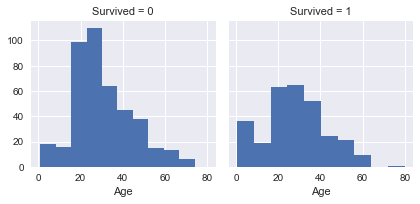

In [251]:
# 可视化分析
#利用可视化来继续验证我们的假设：
'''
数值型：
利用直方图可以用来分析联系的数值型变量
'''

'''
从图中可以看出，age在15-25之前的幸存率较低，5岁一下的幸存率较高;大部分的乘客都在15-35之间
因此决定：
将age纳入训练模型，补充age的空值，将age分段
'''
sns.set(style='darkgrid')
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age')


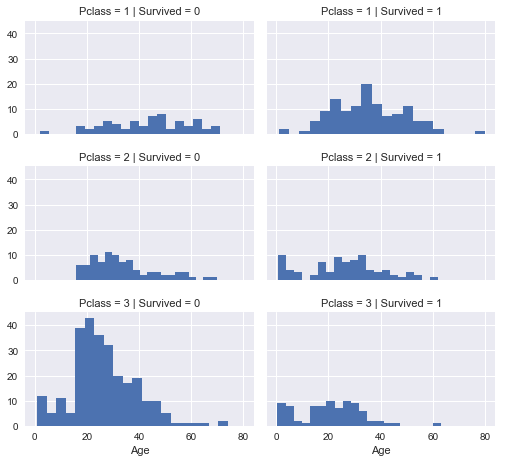

In [252]:
#数值变量和有序变量之间的关联

#将多种变量结合起来展示，适用于数值型和有限个分类的分类变量

'''
观察看到:
pclass=3的乘客最多，但幸存率最低，说明幸存与否和Pclass有关
在pclass=2和pclass=3的婴儿存活率较高；
在pclass=1的乘客大部门都幸存了下来；
在不同的Pcalss中年龄分布不同
结论：
将Pclass纳入训练模型
'''


grid = sns.FacetGrid(train_df, col='Survived', row= 'Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age',bins=20)
grid.add_legend()




c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\seaborn\axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


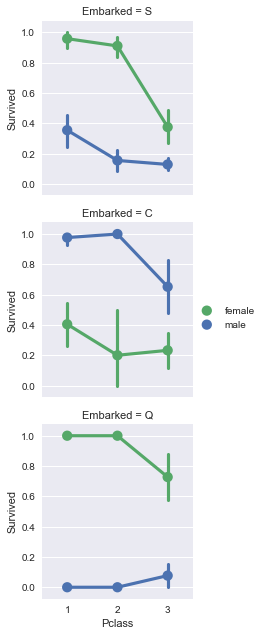

In [253]:
#分类变量之间的关联
'''
可以观察到除了在Embarked=C外，male的幸存率都比价低，也许Embarked变量不是直接作用域
survived，而是通过和Pclass共同影响survived
'''
grid = sns.FacetGrid(train_df, row='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


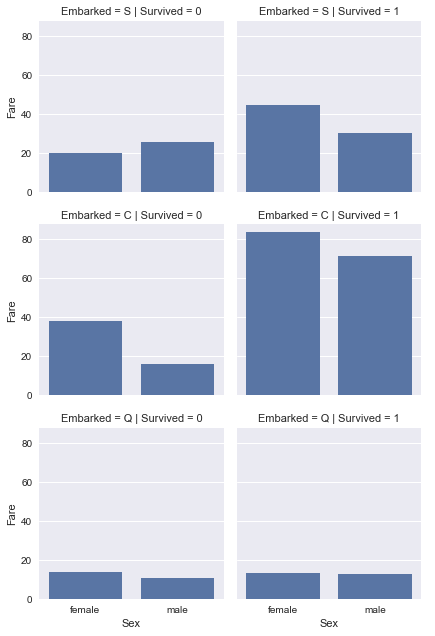

In [254]:
#分类变量和数值变量之间的关联
'''
将分类变量（不含数值型）和数值型变量关联起来：
关联分析Embarked(不含数值的分类变量)、sex（不含数值的分类变量）、fare（数值型变量）
结合起来分析可以看到：
票价越高，幸存率也越高，需要对票价进行分段；
Embarked变量和幸存率相关；
因此得出结论：
将票价区间段纳入训练模型
'''

grid = sns.FacetGrid(train_df, row='Embarked', col='Survived')
grid.map(sns.barplot, 'Sex', 'Fare', ci=None)
grid.add_legend()

In [255]:
#处理数据
'''
到目前为止我们总结了几个假设和决定，但还未对数据进行任何处理，
现在开始要对数据进行规整，处理空值、创造新的变量、分类等
'''
#1.校验数据-剔除无效特征

'''
剔除无用的特征是第一步；根据我们的假设，我们将ticket和cabin两个变量剔除，
训练集和测试集都要去掉以保持一致性
(name和passengerid等下一步从name中提取title后剔除)
'''

print("before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket','Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print('after', train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

before (891, 12) (418, 11) (891, 12) (418, 11)
after (891, 10) (418, 9) (891, 10) (418, 9)


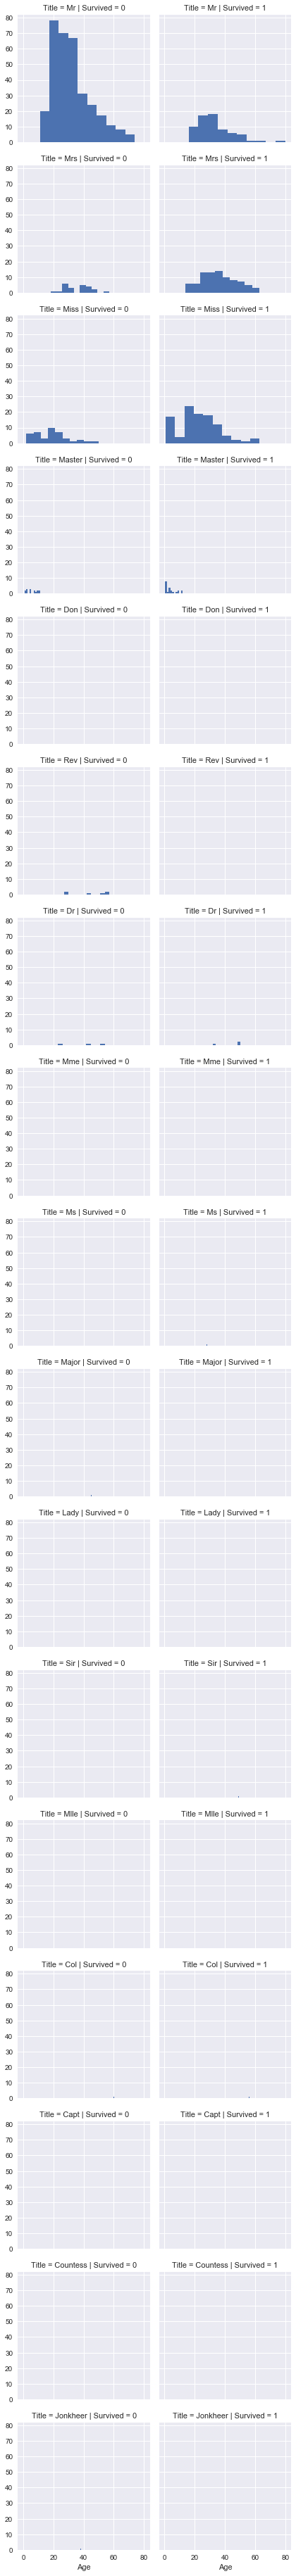

In [256]:
#2.根据已有的变量来创建新的变量
'''
从已知变量中产生新的变量：从name中提取title创建一个title字段
可以观察到：
在不同的title-age区间幸存率不同；
大多数的title能精确的划分年龄段；例如master的平均年龄为5;
所以决定：
将title作为一个新的特征保留；

'''

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

pivot = train_df[['Title', 'Survived']]
pivot = pivot.groupby('Title', as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

grid = sns.FacetGrid(train_df, row='Title', col='Survived')
grid.map(plt.hist, 'Age')

In [257]:
#将出现频率低的title归为一类
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace([
        'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr',
        'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 
    ], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


In [258]:
title_mapping = {'Mr' : 1, "Miss" : 2, "Mrs":3, 'Master':4, 'Rare':'5'}
#根据频率高低编号
for dataset in combine:
    dataset['Title']  = dataset['Title'].map(title_mapping)
    dataset['Title']  = dataset['Title'].fillna(0)

In [259]:
#剔除passengerID和name
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]


In [260]:
#转化分类变量
'''
算法不支持string类型，需要将分类变量转化为数值型
这里先转化sex，embarked后续做处理后再转化
'''
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female' :1, 'male':0}).astype(int)

#补全缺失值（数值型）

'''
补全缺失值，有3种方法：
1.简单的方法是在平均值和标准差之间产生随机数
2.更常见的做法是用其他相关的变量预估缺失值，在这个例子中age、sex和pclass相关，
用pclass和sex的特征组合的age中位数来预估该age的缺失值；
3.结合1和2，用平均值和标准差之间的随机数来代替中位数
'''


In [262]:
#补全age的缺失值
guess_ages = np.zeros((2, 3))

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_df.median()
            guess_ages[i, j] = int(age_guess/0.5 + 0.5) * 0.5
            
    for i in range(0,2):
        for j in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i, j]
            
    dataset['Age'] = dataset['Age'].astype(int)
        


In [263]:
#对age进行分段
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
pivot = train_df[['AgeBand', 'Survived']]
pivot = pivot.groupby(['AgeBand'], as_index=False).mean()
pivot.sort_values(by='AgeBand', ascending= True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [264]:
#将Age转化为有序变量
for dataset in combine:
    dataset.loc[dataset['Age'] <=16, 'Age'] = 0
    dataset.loc[(dataset['Age'] >16 ) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
    

train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

In [265]:
#根据已有的特征来创建新的特征

#结合parch和sibsp创建一个新的变量FamilySize,然后可以剔除parch和sibsp

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] +1

pivot = train_df[['FamilySize', 'Survived']]
pivot = pivot.groupby(['FamilySize'], as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [266]:
#根据familysize再创建一个新的变量IsAlone
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby('IsAlone', as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [267]:
#剔除parch，sibsize，和familysize（isalone性能更好）
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

In [268]:
#再根据age和pclass创建一个新的变量age*class
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass


In [269]:
# Completing a categorical feature补全分类变量
#embarked有两个缺失值，我们将频数最大的值进行填充
freq_port = train_df.Embarked.dropna().mode()[0]

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
pivot = train_df[['Embarked', 'Survived']]
pivot = pivot.groupby(['Embarked'], as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [270]:
# 将Embarked转化为数值型
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map({'S':0 ,'C':1, 'Q':2}).astype(int)

In [271]:
#测试集中fare有缺失值，用中位数来填充
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

In [272]:
#将fare分段
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
pivot = train_df[['FareBand', 'Survived']]
pivot = pivot.groupby(['FareBand'], as_index=False).mean()
pivot.sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [273]:
for dataset in combine:
    dataset.loc[dataset['Fare']<=7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] >7.91 )& (dataset['Fare'] <= 14.454), 'Fare'] =1
    dataset.loc[(dataset['Fare'] >14.454 )& (dataset['Fare'] <= 31.0), 'Fare'] =1
    dataset.loc[(dataset['Fare'] >31.0 ), 'Fare'] =1

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
  

In [274]:
#Model, predict and solve
'''
数据已经处理完成，接下来要开始训练模型了，我们的任务是一个分类回归的监督学习任务，
因此适用的模型算法有：
Logistic Regression/KNN/SVM/Naive Bayes Classifier/Decision Tree/Random Forrest/
preception/Artificial neural network/ Relevance Vector Machine or RVM
'''

X_train = train_df.drop('Survived', axis=1)
Y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis=1).copy()


In [275]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train)*100, 2)
print(acc_log)

80.36


In [276]:
'''
可以观察到：
sex是最高的正系数；sex越高（female=1越多）,幸存的可能性越大；
相反，Pclass是最大的负系数，Pcalss是越大，幸存可能性越小；
age*class这个人工特征是一个很好的特征变量，是第二高的负系数；
title是第二高的正系数；
'''
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df['Correlation'] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.197462
5,Title,0.383890
4,Embarked,0.286647
2,Age,0.273838
6,IsAlone,0.235931
3,Fare,0.108362
7,Age*Class,-0.298737
0,Pclass,-0.691305


In [277]:
#SVM支持向量机 , 分数和示例不同？

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train)* 100, 2)
print(acc_svc)

82.72


In [278]:
#KNN/k-近邻算法
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train)*100, 2)
print(acc_knn)

82.27


In [279]:
#Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussion = round(gaussian.score(X_train, Y_train)*100, 2)
print(acc_gaussion)

72.28


In [280]:
#Perceptron感知机

perceptron = Perceptron(max_iter=5, tol=None)
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train)*100, 2)
print(acc_perceptron)

74.86


In [281]:
# Linear SVC 

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train)*100, 2)
print(acc_linear_svc)

78.79


In [282]:
# Stochastic Gradient Descent

sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train)*100,2)
print(acc_sgd)

76.43


In [283]:
#Decision Tree决策树

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) *100, 2)
print(acc_decision_tree)

84.96


In [284]:
# Random Forest随机森林

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) *100, 2)
print(acc_random_forest)

84.96


In [285]:
#模型评估
'''
random forest 和 decision tree 虽然分数一样，但是选择random forest，
因为random forest纠正了decision tree的过拟合问题
'''

models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
             'Random Forest', 'Naive Bayes', 'Perceptron',
              'Stochastic Gradient Decent', 'Linear SVC', 'Decision Tree'],
    'Score' : [acc_svc, acc_knn, acc_log,acc_random_forest,
               acc_gaussion , acc_perceptron, acc_sgd,
              acc_linear_svc, acc_decision_tree]
})

models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,84.96
8,Decision Tree,84.96
0,Support Vector Machines,82.72
1,KNN,82.27
2,Logistic Regression,80.36
7,Linear SVC,78.79
6,Stochastic Gradient Decent,76.43
5,Perceptron,74.86
4,Naive Bayes,72.28


In [286]:
#保存结果
submission = pd.DataFrame({
    "PassengerId" : test_df["PassengerId"],
    'Survived' : Y_pred
})

In [287]:
submission.to_csv('submission.csv', index=False)